# STA 220 Assignment 4
# Jake Tierney, Student ID: 913235409

Due __March 8, 2024__ by __11:59pm__. Submit your work by uploading it to Gradescope through Canvas.

Instructions:

1. Provide your solutions in new cells following each exercise description. Create as many new cells as necessary. Use code cells for your Python scripts and Markdown cells for explanatory text or answers to non-coding questions. Answer all textual questions in complete sentences.
2. The use of assistive tools is permitted, but must be indicated. You will be graded on you proficiency in coding. Produce high quality code by adhering to proper programming principles. 
3. Export the .jpynb as .pdf and submit it on Gradescope in time. To facilitate grading, indicate the area of the solution on the submission. Submissions without indication will be marked down. No late submissions accepted. 
4. If test cases are given, your solution must be in the same format. 
5. The total number of points is 10. 

__Exercise 1__ Lets retrieve data from the [CIA World Factbook](https://www.cia.gov/the-world-factbook/) and visualize parts of it. 

__(a)__ Using devtools, find a way to retrieve the names of all listed world entities. In order to navigate to their respective site, I assembled the path by processing the country names. To this end, __(i)__ write a function `process_names` that processes the name as string according to the requests query parameter. _Run:_ 
```
process_names('Falkland Islands (Islas Malvinas)')
```

In [1]:
# Importing requisite modules for this assignment
import requests as rq
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import json as js
import time
import lxml
import xmltodict
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, Slider, CustomJS
from bokeh.layouts import column
from bokeh.io import output_notebook

In [2]:
# Problem a, part (i)

# Defining the function that takes a country name string as input and outputs a string in the proper format
def process_names(country_string):
    
    # Making all characters lowercase
    lowercase = country_string.lower()

    # Further replacing all whitespace characters with dashes
    dashes = lowercase.replace(' ', '-')

    # Further removing any commas
    commas = dashes.replace(',', '')

    # Further removing any parentheses
    final = commas.replace('(', '')
    final = final.replace(')', '')
    
    return final

# Printing test cases
print('SOLUTION:')
print(process_names('Falkland Islands (Islas Malvinas)'))
print(process_names('French Southern and Antarctic Lands'))
print(process_names('Bahamas, The'))

SOLUTION:
falkland-islands-islas-malvinas
french-southern-and-antarctic-lands
bahamas-the


\
__(ii)__ Obtain all world entity names. _How many have you found? Hint: I could not retrieve data for all 266 entities that the CIA WFB claims to have._

In [3]:
# Problem a, part (ii)

# Creating an empty list to store entity names in
entities = []

# Initializing the webdriver
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
url = "https://www.cia.gov/the-world-factbook/countries/"
driver.get(url)

# For loop to extract and store all entity names
for page_number in range(1, 23):
    
    # Getting the page source using Selenium
    page_source = driver.page_source
    
    # Parsing the HTML content with BeautifulSoup
    data = BeautifulSoup(page_source, 'html.parser')
    
    # Finding and extracting entity links using BeautifulSoup
    entity_links = data.select('a.inline-link')
    
    # Extracting entity names
    entity_names = [link.text.strip() for link in entity_links]
    for entity_name in entity_names:
        entities.append(entity_name)

    # Resting once to make the navigation button clickable
    if page_number == 1:
        time.sleep(2)
    
    # Navigating to the next page
    try:
        next_page_button = driver.find_element(By.XPATH, "//span[@class='pagination__arrow-right' and @data-testid='right-arrow']")
        next_page_button.click()
    except Exception as e:
        break

# Closing the browser window
driver.quit() 

# Printing the length of the entities list
len(entities)

262

SOLUTION: I found 262 entity names on the CIA World Factbook website.

__(iii)__ Write a function `get_info` takes a country name as string as input and return all the information as json that is displayed on its respective site. Use the retrieved data set for the next exercises. _Hint: If you rate-limit your requests (you should!) this may take up to 10 minutes._

In [4]:
# Problem a, part (iii)

# Defining function get_info that takes string of country name as input and returns a json dictionary of all info
def get_info(country_name):

    # Creating URL for given country
    country_url = 'https://www.cia.gov/the-world-factbook/countries/' + process_names(country_name) + '/'

    # Requesting all relevant information from that countrie's page
    response = rq.get(country_url)
    data = BeautifulSoup(response.text, 'html.parser')
    target_div = data.find('div', class_='col-lg-6 col-md-12 col-sm-12 border-left-black pb120-90 pt120-45 content-area-content article-content')

    # Creating result_list to store the div tags
    result_list = []

    # Iterating through div tags with id attribute
    if target_div != None:
        for div_tag in target_div:
            result_list.append(str(div_tag))

    else:
        page_dict_na = {'country': country_name}
        return page_dict_na

    # Creating page_list to store the key names and data 
    page_list = []

    # Iterating over all of the sections of the country's page and appending the section header and data to the page_list
    for i in range(0, len(result_list)):
        if i != 1:
            key = result_list[i][result_list[i].find('id=') + 4:result_list[i].find('<h2>') - 2]
            data = result_list[i]
            #data = result_list[i][result_list[i].find('/h3') + 4:result_list[i].find('</div></div>')]
            page_list.append((key, data))

    # Creating the final dictionary of page contents with a country key
    page_dict = {
        'country': country_name
    }

    # Appending the different sections of the country page to the dictionary
    for key, data in page_list:
        page_dict[key] = data

    return page_dict

# Creating a list to append country info dictionaries to
countries_data = []

# For loop to get info for each country in the entities list
for c in range(0, len(entities)):
    country_info = get_info(entities[c])
    countries_data.append(country_info)
    time.sleep(0.05)

__(b)__ Lets learn about the newest updated data points in the CIA world factbook - the merchant marine! __(i)__ Write a function `ports` that returns a list of all major seaports of a given country. _Run:_

```
ports('United States')
```

In [5]:
# Problem b, part (i)

# Defining function that takes country name string as input and returns list of all major seaports
def ports(country):

    # Iterate through the countries database to select the dictionary of the input country
    for i in countries_data:
        if i['country'] == country:
            country_info = i
            break

    # Subset to only the transportation section for the given country
    transportation = country_info['transportation']

    # If statement that conditions on the transportation section containing a seaports subsection
    if 'seaport' in transportation:

        # subset to only the part of the transportation section containing the seaports info
        ports_string = transportation.split('seaport')[1]

        # Slicing only the major seaport cities
        start_slice = transportation.split('seaport')[1].find('</strong>')
        end_slice = transportation.split('seaport')[1].find('<strong>')
        ports_sliced = ports_string[start_slice:end_slice].split('<')

        # Appending only the city names to our list of ports
        ports_list = []
        for i in ports_sliced:
            if ':' not in i and 'br/>' not in i and i != '' and i != '/strong> ' and i != 'em>' and i != '/p' and 'p>' not in i and 'div>' not in i and 'h3' not in i and 'href=' not in i and '/a>' not in i:
                ports_list.append(i.replace('/em> ', '').replace('/strong> ', '').replace(' located on the Caspian Sea', '').
                                 replace('Atlantic Ocean (Caribbean) - ', '').replace('Mediterranean Sea - ', '').
                                 replace('Caspian Sea - ', '').replace('/em>', ''))

        # Collapsing the ports_list into a one dimensional list of ports
        final_ports = [port.strip() for entry in ports_list for port in re.split(r', |; ', entry)]

        # Removing any parentheses from the port names
        pattern = re.compile(r'\([^)]*\)')
        final_ports = [pattern.sub('', string) for string in final_ports]
        final_ports = [string.rstrip() for string in final_ports]

    # If transportation section does not contain seaports, set the final list as empty
    else:
        final_ports = []
        
    return final_ports


# Printing some test cases
print('SOLUTION:')
print(ports('United States'))
print(ports('Mongolia'))
print(ports('Greece'))

SOLUTION:
['Charleston', 'Hampton Roads', 'New York/New Jersey', 'Savannah', 'Long Beach', 'Los Angeles', 'Oakland', 'Seattle/Tacoma', 'Houston']
[]
['Aspropyrgos', 'Pachi', 'Piraeus', 'Thessaloniki']


__(ii)__ Lets put a marker on a world map corresponding to the location of all major seaports that you retrieved. Use the [Nominatim](https://nominatim.org/) API to get latitute-longitude pairs. Make structured queries and pass the `city` and `country` keys. Use the first value that is returned. 

_Print the world map. Name three markers that are apparently misplaced._

Text(0.5, 1.0, 'Major Seaports Around the World')

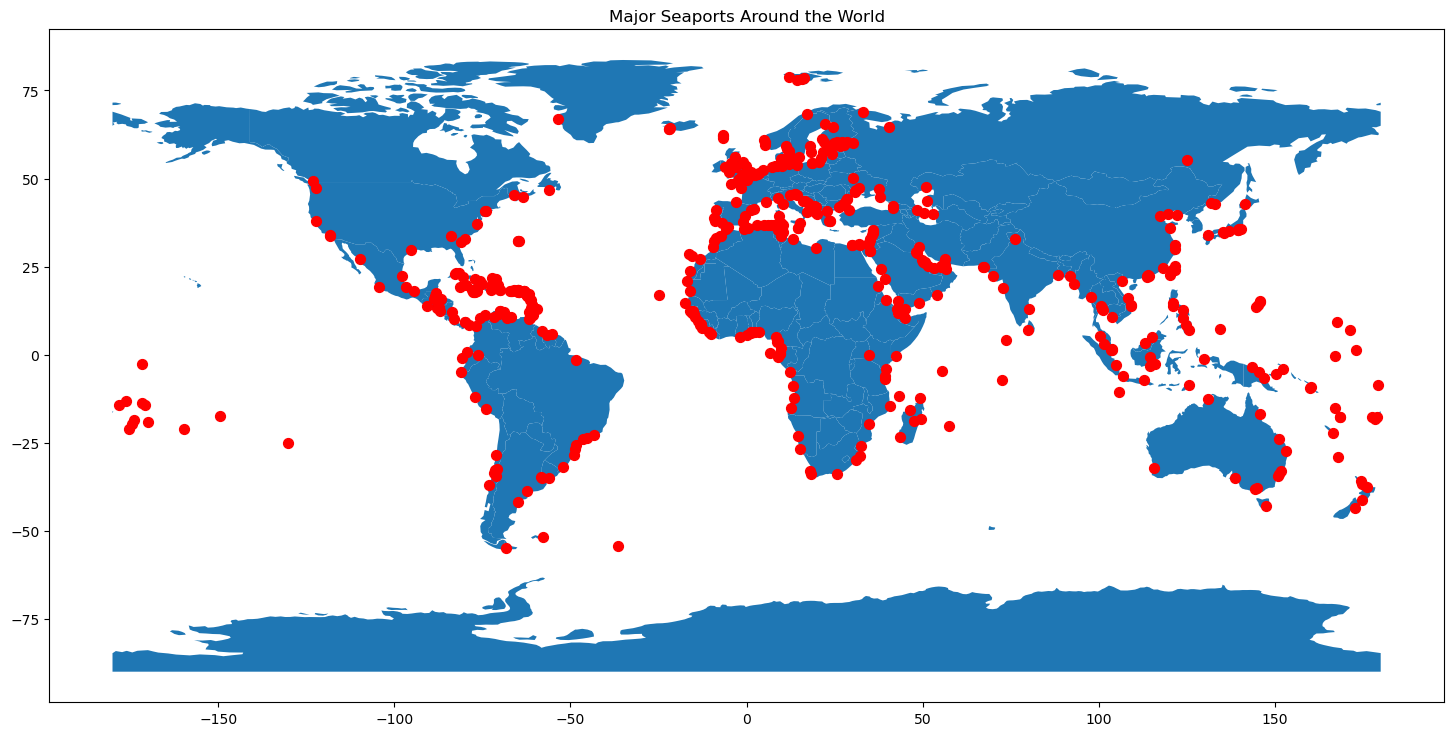

In [6]:
# Problem b, part (ii)

# Initializing the seaports dataframe
final_df = pd.DataFrame({'Country': [], 'Port': []})

# Iterating across the country info dictionary
for i in countries_data:

    # Conditioning on if the country page has a transportation section
    if 'transportation' in i:

        # Running the ports function for the given country
        country_ports = ports(i['country'])

        # Conditioning on whether or not the country has any major seaports
        if len(country_ports) > 0:

            # Creating a list of the country name repeated as many times as there are ports
            country_name = [i['country']] * len(country_ports)

            # Creating a data dictionary that contains two variables: the country name and the country ports
            ports_dict = {
                'Country': country_name,
                'Port': country_ports
            }

            # Creating a pandas dataframe containing the country name and the port name
            ports_df = pd.DataFrame(ports_dict)
            final_df = pd.concat([final_df, ports_df], ignore_index=True)

# Initializing latitude and longitude variables
latitude = []
longitude = []

# Initializing the nominatim search tool
nom_url = "https://nominatim.openstreetmap.org/search"

# Iterating across all entries in the ports dataframe
for i in range(0, len(final_df['Country'])):

    # Defining the city and country for that given row
    city = final_df.iloc[i, 1]
    country = final_df.iloc[i, 0]

    # Defining the parameters for the nominatim request
    params = {
        'q': f"{city}, {country}",
        'format': 'json'
    }

    # Requesting the nominatim data and converting it to json
    response = rq.get(nom_url, params=params)
    data = response.json()

    # Extracting the latitude and longitude for each city, if they exist
    if data:
        # Extracting latitude and longitude from the first result
        lat = float(data[0]['lat'])
        lon = float(data[0]['lon'])
    else:
        lat = None
        lon = None

    # Appending lat and lon to the latitude and longitude variables
    latitude.append(lat)
    longitude.append(lon)

    # Rate limiting the requests
    time.sleep(0.05)

# Appending latitude and longitude variables to our ports df
final_df['Latitude'] = latitude
final_df['Longitude'] = longitude

# Suppressing any warning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

# Reading the world map dataset
wm = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating a GeoDataFrame for the markers from our final_df dataset
markers_gdf = gpd.GeoDataFrame(final_df, geometry=gpd.points_from_xy(final_df['Longitude'], final_df['Latitude']))

# plotting world map
ax = wm.plot(figsize=(18, 9))

# Plotting the markers
markers_gdf.plot(ax=ax, color='red', marker='o', markersize=50)

# Adding title
plt.title("Major Seaports Around the World")

SOLUTION: Three seaport markers that appear to be misplaced are Vostochnyy (Russia), Kandla (India), and Kisumu (Kenya).

__(iii)__ Amongst all countries with a major seaport, return the four that have the largest fleet of _bulk carriers_. Amongst all countries with no coastline, return the four that have the largest merchant marine fleet overall. 

In [7]:
# Problem b, part (iii) 

# Creating a list of unique countries that have a major seaport
seaport_countries = list(final_df['Country'].unique())

# Initializing a variable to store country name and number of bulk carriers
country = []
bulk_carriers = []

# Iterating over each dictionary in the countries_data list
for i in countries_data:

    # Conditioning on whether each country in countries_data is in the seaport_countries list
    if i['country'] in seaport_countries:

        # Appending country name to the country name variable
        country.append(i['country'])

        # Conditionally appending the number of bulk carriers that country has to bulk_carriers
        if 'bulk carrier' in i['transportation']:
            bulk_carriers.append(i['transportation'].split('bulk carrier ')[1][0:i['transportation'].split('bulk carrier ')[1].find(',')])

        # Appending 0 if bulk carriers are not mentioned on this country's page
        else:
            bulk_carriers.append(0)

# combining country name and number of carriers into a pandas df
carriers_df = pd.DataFrame({'Country': country, 'Carriers': bulk_carriers})
carriers_df['Carriers'][6] = 1
carriers_df['Carriers'] = carriers_df['Carriers'].astype(int)

# Sorting carriers_df based on the Carriers column in descending order
carriers_sorted = carriers_df.sort_values(by='Carriers', ascending=False)

# Initializing lists to contain non-seaport country names and total merchant marine fleet
nonsea_country = []
total_fleet = []

# Iterating over each dictionary in the countries_data list
for i in countries_data:

    # Conditioning on whether each country in countries_data is in the seaport_countries list
    if i['country'] not in seaport_countries and i['country'] != 'World':

        # Appending country name to the nonsea_country name variable
        nonsea_country.append(i['country'])

        # Conditionally appending the total merchant marine fleet that a country has to total_fleet
        if 'transportation' in i and 'Merchant marine' in i['transportation']:
            total_fleet.append(i['transportation'].split('Merchant marine')[1][i['transportation'].split('Merchant marine')[1].find('</strong>') + 10:i['transportation'].split('Merchant marine')[1].find('<br/>') - 7]
)

        # Appending 0 if merchant marine is not mentioned on this country's page
        else:
            total_fleet.append(0) 

# combining country name and merchant marine fleet into a pandas df
fleet_df = pd.DataFrame({'Country': nonsea_country, 'Fleet': total_fleet})
fleet_df['Fleet'][22] = 1005
fleet_df['Fleet'] = fleet_df['Fleet'].astype(int)

# Sorting carriers_df based on the Carriers column in descending order
fleet_sorted = fleet_df.sort_values(by='Fleet', ascending=False)

# Printing the top 4 countries with a major seaport ranked by number of bulk carriers
print(carriers_sorted[0:4])

          Country  Carriers
129        Panama      2732
152     Singapore       591
104         Malta       490
10   Bahamas, The       345


SOLUTION: The top four countries that have a major seaport ranked by number of Bulk Carriers are Panama (2732), Singapore (591), Malta (490), and The Bahamas (345).

In [8]:
# Printing the top 4 countries without a major seaport ranked by total merchant marine fleet
print(fleet_sorted[0:4])

       Country  Fleet
22     Czechia   1005
47    Mongolia    318
16    Cameroon    198
42  Luxembourg    147


SOLUTION: The top four countries that do not have a major seaport ranked by total merchant marine fleet are Cyprus (1005), Mongolia (318), Cameroon (198), and Luxembourg (147).

__(c)__ Now, lets classify whether a country is or has been controlled by the United Kingdom by analyzing the provided background information text. __(i)__ Implement a (very simple!) classification method that performs this task. My function `was_british` correctly identifies the countries of Pakistan and Russia, but incorrectly classifies Spain and the United States. 

_How many world entities do you find to be current or former parts of the British Empire?_

In [9]:
# Problem c, part (i)

# Definining a function was_british that takes a country name as input and outputs their British control classification
def was_british(country_name):
    
    # Iterate through the countries database to select the dictionary of the input country
    for i in countries_data:
        if i['country'] == country_name and 'introduction' in i:
            country_background = i['introduction']
            break
        elif i['country'] == country_name and 'introduction' not in i:
            country_background = ''
            break

    # Defining the criteria for classifying whether a country was ever under British rule
    crit1 = 'Britain' in country_background
    crit2 = 'britain' in country_background
    crit3 = 'British' in country_background
    crit4 = 'british' in country_background
    crit5 = 'British Empire' in country_background
    crit6 = 'british empire' in country_background
    crit7 = 'British empire' in country_background
    crit8 = 'british Empire' in country_background

    # Combining the criteria into our final classification variable
    classification = crit1 or crit2 or crit3 or crit4 or crit5 or crit6 or crit7 or crit8

    return classification

# Creating lists that will store country names and was_british classifications
wasbritish_country = []

# Iterating over every country in countries_data and storing their country name if they were classified as British
for i in countries_data:
    if was_british(i['country']) == True:
        wasbritish_country.append(i['country'])

# Printing the length of wasbritish_country
len(wasbritish_country)

103

SOLUTION: Based on my classification, I found 103 countries to be currently or previously under British rule.

__(ii)__ Retrieve the ISO codes from [here](https://www.cia.gov/the-world-factbook/references/country-data-codes/) and use them to color all countries on a world map that you have determined to be former parts of the British Empire. The map should look something like [this](https://en.wikipedia.org/wiki/British_Empire#/media/File:The_British_Empire_5.png). 

Text(0.5, 1.0, 'Countries Classified as Currently or Previously Under British Rule')

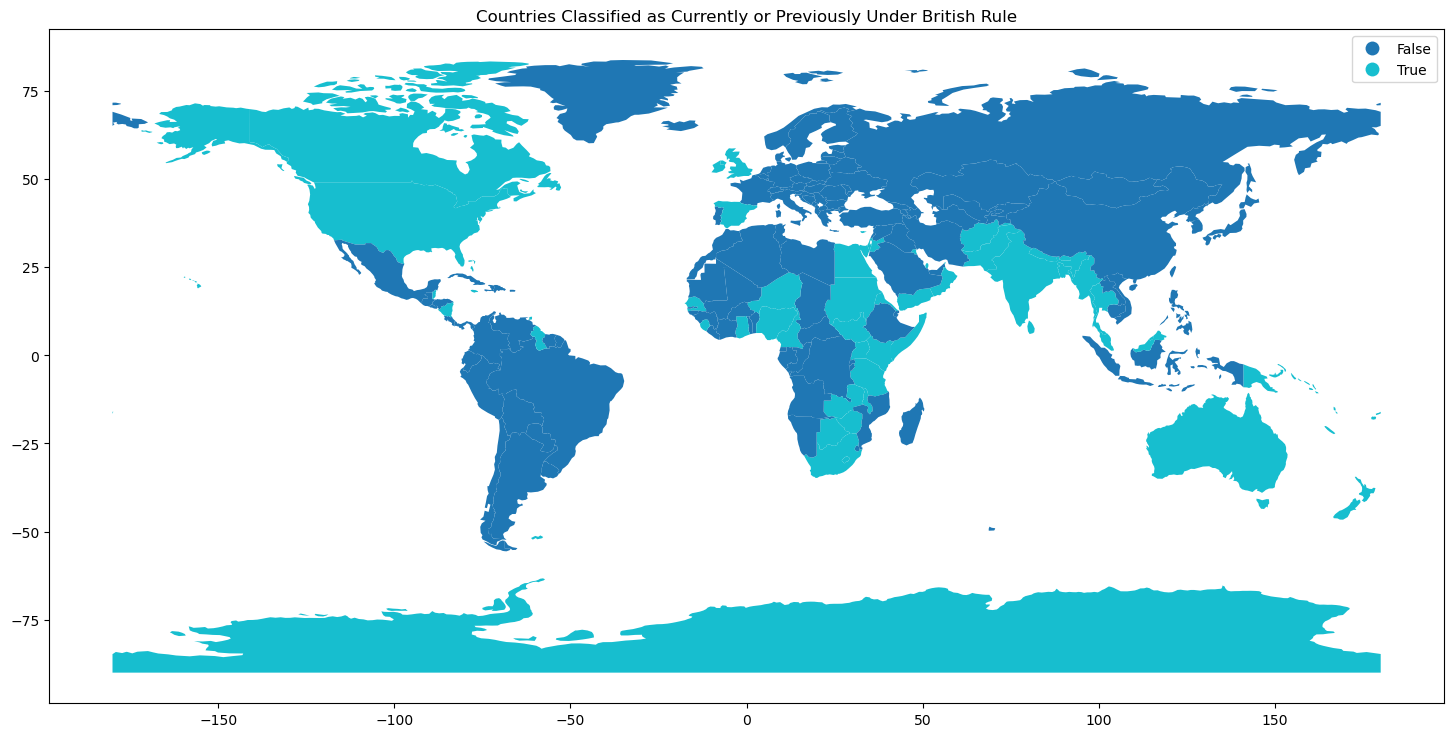

In [10]:
# Problem c, part (ii)

# Setting the url of interest
url = "https://www.cia.gov/the-world-factbook/references/country-data-codes/"

# Requesting data from the page
response = rq.get(url)

# Parsing the HTML content using BeautifulSoup
data = BeautifulSoup(response.text, 'html.parser')

# Finding the table containing ISO codes
iso_table = data.find('table')

# Splitting out each row of the table
table_rows = iso_table.find_all('tr')

# Creating lists to store country_name and iso variables
c_name = []
iso = []

# Store the country name and ISO code for each country
for row in table_rows:
    columns = row.find_all(['th', 'td'])
    row_data = [column.text.strip() for column in columns]
    c_name.append(row_data[0])
    iso.append(row_data[1])

# Removing the first entry of c_name and iso
c_name = c_name[1:]
iso = iso[1:]

# Creating a was_british variable that is True if the country name is in wasbritish_country and False otherwise
wasbritish = []
for i in range(0, len(c_name)):
    if c_name[i] in wasbritish_country:
        wasbritish.append(True)
    else:
        wasbritish.append(False)

# Create dataframe of country names and iso codes
iso_df = pd.DataFrame({'Country': c_name, 'ISO': iso, 'was_british': wasbritish})

# Suppressing any warning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

# Reading the world map dataset, renaming the iso code column
wm = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
wm.rename(
    columns={"iso_a3": "ISO"},
    inplace=True,
)

# Merging iso_df dataframe into the wm dataframe
wm = pd.merge(wm, iso_df, how='left', on="ISO")

# plotting world map
ax = wm.plot(figsize=(18, 9), column = "was_british", legend = True)

# Adding title
plt.title("Countries Classified as Currently or Previously Under British Rule")

__(d)__ Lets build our own population pyramide (with only three steps) according to the obtained data (`0-14`, `15-64`, `65+`). Given the current health expenditure as threshold, we want to obtain create a population pyramide for all aggregated population values. __(i)__ Assemble a data frame that given a threshold shows the aggregated population values of all data points which current health expenditure does not exceed the threshold, separated by gender. The first four rows of data frame `df` are given below. 

_How many distinct thresholds do you find?_

In [11]:
# Problem d, part (i)

# Initializing a list to store the rowdata for each country
population_list = []

# Iterating over every country in countries_data
for i in range(0, len(countries_data)):

    # Subsetting to current country
    case = countries_data[i]

    # Storing the country name
    name = case['country']

    # Not appending a row for the 'World' entry
    if name != 'World':

        # Checking if the country has a People and Society section
        if 'people-and-society' in case:

            # Conditionally storing healthcare expenditure
            if 'Current health expenditure' in case['people-and-society']:
                health = case['people-and-society'][case['people-and-society'].find('Current health expenditure'):]
                if health[health.find('<p>') + 3:health.find('GDP') - 5][0:2] != 'NA':
                    health_pct = float(health[health.find('<p>') + 3:health.find('GDP') - 5])
                else:
                    health_pct = 0
            else:
                health_pct = 0

            # Conditionally creating the age structure sections and storing age/gender populations
            if 'Age structure' in case['people-and-society']:
                age014 = case['people-and-society'][case['people-and-society'].find('0-14 years:'):case['people-and-society'].find('15-64 years')]
                age1564 = case['people-and-society'][case['people-and-society'].find('15-64 years:'):case['people-and-society'].find('65 years and over:')]
                age65 = case['people-and-society'][case['people-and-society'].find('65 years and over:'):case['people-and-society'].find('population pyramid')]

                if 'NA' not in age014:
                    m014 = int(age014[age014.find('(male') + 6: age014.find('/female')].replace(',', ''))
                    f014 = int(age014[age014.find('/female') + 8: age014.find(')<br/>')].replace(',', ''))
                else:
                    m014 = 0
                    f014 = 0

                if 'NA' not in age1564:
                    m1564 = int(age1564[age1564.find('(male') + 6: age1564.find('/female')].replace(',', ''))
                    f1564 = int(age1564[age1564.find('/female') + 8: age1564.find(')<br/>')].replace(',', ''))
                else:
                    m1564 = 0
                    f1564 = 0

                if 'NA' not in age65:
                    m65 = int(age65[age65.find('(male') + 6: age65.find('/female')].replace(',', ''))
                    f65 = int(age65[age65.find('/female') + 8: age65.find(')<')].replace(',', ''))
                else:
                    m65 = 0
                    f65 = 0
        
            else:
                m014 = 0
                f014 = 0
                m1564 = 0
                f1564 = 0
                m65 = 0
                f65 = 0

        else:
            health = 0
            m014 = 0
            f014 = 0
            m1564 = 0
            f1564 = 0
            m65 = 0
            f65 = 0
        
        # Creating a row vector containing country name and relevant data
        rowdata = [name, health_pct, m014, f014, m1564, f1564, m65, f65]

        # Appending this row vector to population_list
        population_list.append(rowdata)

    else:
        continue

# Defining the column names for our dataframe
colnames = ['Country', 'Healthcare', 'M0-14', 'F0-14', 'M15-64', 'F15-64', 'M65', 'F65']

# Creating a pandas dataframe of the population data for each country
pop_df = pd.DataFrame(population_list, columns=colnames)

# Creating empty lists to contain the age range, male, female, and healthcare threshold variables
age_range_final = []
male_totals_final = []
female_totals_final = []
threshold_final = []

# Iterating over every unique healthcare expenditure value, excluding zero
for i in sorted(pop_df['Healthcare'].unique())[1:]:

    # Defining the sum of the male and female populations of each age range across all countries that are above the threshold
    total_m014 = pop_df.loc[pop_df['Healthcare'] > i, 'M0-14'].sum()
    total_f014 = pop_df.loc[pop_df['Healthcare'] > i, 'F0-14'].sum()
    total_m1564 = pop_df.loc[pop_df['Healthcare'] > i, 'M15-64'].sum()
    total_f1564 = pop_df.loc[pop_df['Healthcare'] > i, 'F15-64'].sum()
    total_m65 = pop_df.loc[pop_df['Healthcare'] > i, 'M65'].sum()
    total_f65 = pop_df.loc[pop_df['Healthcare'] > i, 'F65'].sum()

    # Appending the vectors to the final data lists
    age_range_final.append('0-14 years')
    age_range_final.append('15-64 years')
    age_range_final.append('65 years and over')
    male_totals_final.append(total_m014)
    male_totals_final.append(total_m1564)
    male_totals_final.append(total_m65)
    female_totals_final.append(total_f014)
    female_totals_final.append(total_f1564)
    female_totals_final.append(total_f65)
    threshold_final.append(i)
    threshold_final.append(i)
    threshold_final.append(i)

# combining the column vectors into a pandas dataframe
pyramid = pd.DataFrame({'Groups': age_range_final, 'Male': male_totals_final, 'Female': female_totals_final, 'Threshold': threshold_final})

# Printing the pyramid dataframe
pyramid

,Groups,Male,Female,Threshold
0,0-14 years,994384389,935440980,1.7
1,15-64 years,2586792728,2523983250,1.7
2,65 years and over,355637800,440999220,1.7
3,0-14 years,994244024,935301681,2.0
4,15-64 years,2586508240,2523611721,2.0
...,...,...,...,...
271,15-64 years,3703,3664,18.8
272,65 years and over,318,547,18.8
273,0-14 years,0,0,21.5
274,15-64 years,0,0,21.5


In [12]:
# Printing the number of unique thresholds in the pyramid dataframe
len(sorted(pyramid['Threshold'].unique()))

92

SOLUTION: I found 92 unique healthcare expenditure thresholds across all of the individual country pages.

__(ii)__ Using `bokeh.io`, create a client-based interactive opulation pyramid that displays the data from (i) according to a set threshold (or the closest threshold that exists). Make sure that the pyramid is well crafted, similar to [this](https://en.wikipedia.org/wiki/Population_pyramid#/media/File:Angola_population_pyramid_2005.svg), but with a slider and only three population groups. 

_Either provide a link to a site that hosts the interactive graphic, or provide a non-interactive for threshold value `10`._

Loading BokehJS ...

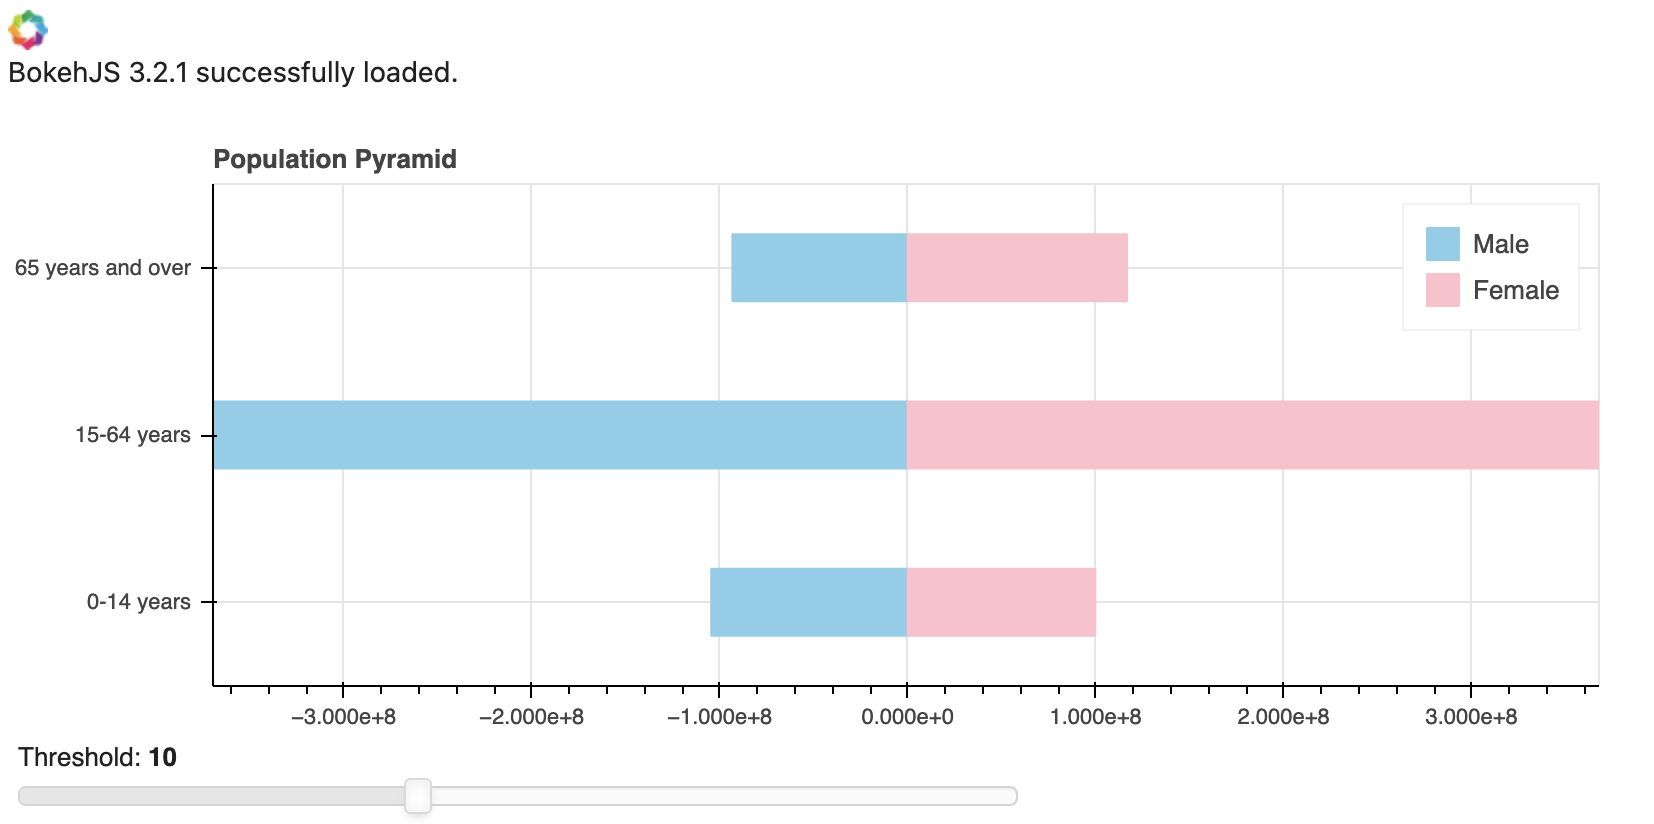

In [21]:
# Defining a function that subsets the pyramid dataframe based on what the input threshold is
def pyramid_subset(threshold):
    sub = pyramid.loc[abs(pyramid['Threshold'] - threshold) == min(abs(pyramid['Threshold'] - threshold))]
    return sub
pyramid['Male'] = -pyramid['Male']

output_notebook()

# Setting the initial threshold to zero
initial = pyramid_subset(10)

# Creating a ColumnDataSource out of the initial pyramid dataframe
source = ColumnDataSource(initial)

# Create a figure
xrange = (min(initial['Male']), max(initial['Female']))
p = figure(x_range = xrange, y_range=initial['Groups'], height = 300, width=800, title="Population Pyramid", toolbar_location=None, tools="")

# Add horizontal bars for male and female populations
malebars = p.hbar(y='Groups', right='Male', height=0.4, color="skyblue", source=source, legend_label="Male")
femalebars = p.hbar(y='Groups', right='Female', height=0.4, color="pink", source=source, legend_label="Female")

# Add slider for threshold
threshold_slider = Slider(start=0, end=25, value=10, step=0.1, title="Threshold", width = 500)

# Creating and plotting the final layout
layout = column(p, threshold_slider)
show(layout)
from IPython.display import Image
Image(filename='Chart.png') 